# How well does Apple Watch Cycle Tracking data fit clinical fertility principles?
### Based on 4 years of wrist temperature and manual flow tracking

## Introduction

**About this project:**
Hi, I'm Phoebe! I'm a data engineer. You might have found this project at my [personal site](https://phoebewing.me) or from my [LinkedIn](https://www.linkedin.com/in/phoebecwing). 
I created this project to explore how well my Apple Watch wrist temperature data corresponds with typically expected patterns
in temperature and fertility cycle phases. I perform an exploratory analysis here, comparing the resulting insights with various [fertility science principles](https://my.clevelandclinic.org/health/articles/21065-basal-body-temperature). The major factor of interest is that the "gold standard" for temperature in the domain of women's health is basal body temperature (BBT) which is taken internally, whereas Apple Watch measures external wrist temperature, which is why I want to test how well my personal data fits these basic principles.

- Tools I used:
    - [Simple Health Export CSV](https://www.ericwolter.com/projects/apple-health-export/) for iOS by Eric Wolter
    - Pandas, Numpy, MatPlotLib, Seaborn, SciPy

**Key Findings:**
- Temperature readings follow a clear bimodal distribution
- Per cycle, average temperature undergoes a clear shift around the same cycle dates, indicative of a cycle phase change.

# Phase 1
## Apple Health Wrist Temperature Analysis
- Import and normalize wrist temperature data
- Compute key statistics on temperature distribution
- Visualize temperature over time and temperature distribution

In [37]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [13]:
# 2. Load in raw data

df_raw = pd.read_csv('../data/raw/HKQuantityTypeIdentifierAppleSleepingWristTemperature_2026-01-26_10-29-06_SimpleHealthExportCSV.csv', skiprows=1)

print(f"Data loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
df_raw.head()

Data loaded: 1101 rows, 10 columns


,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion
0,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-05 03:30:01 +0000,2022-10-05 11:01:00 +0000,degF,97.062257,1
1,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-06 02:56:16 +0000,2022-10-06 11:37:07 +0000,degF,97.059470,1
2,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-07 03:04:03 +0000,2022-10-07 11:00:21 +0000,degF,97.222864,1
3,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-08 04:00:01 +0000,2022-10-08 14:48:59 +0000,degF,97.503098,1
4,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-09 04:00:00 +0000,2022-10-09 12:47:03 +0000,degF,97.664851,1


In [14]:
# 3. Initial Inspection

print("=== Data Info ===")
print(df_raw.info())

print("\n=== Column Names ===")
print(df_raw.columns.tolist())

print("\n=== First Few Rows ===")
display(df_raw.head())

print("\n=== Basic Statistics ===")
display(df_raw.describe())

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                1101 non-null   object 
 1   sourceName          1101 non-null   object 
 2   sourceVersion       1101 non-null   object 
 3   productType         1101 non-null   object 
 4   device              1101 non-null   object 
 5   startDate           1101 non-null   object 
 6   endDate             1101 non-null   object 
 7   unit                1101 non-null   object 
 8   value               1101 non-null   float64
 9   HKAlgorithmVersion  1101 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 86.1+ KB
None

=== Column Names ===
['type', 'sourceName', 'sourceVersion', 'productType', 'device', 'startDate', 'endDate', 'unit', 'value', 'HKAlgorithmVersion']

=== First Few Rows ===


,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion
0,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-05 03:30:01 +0000,2022-10-05 11:01:00 +0000,degF,97.062257,1
1,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-06 02:56:16 +0000,2022-10-06 11:37:07 +0000,degF,97.059470,1
2,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-07 03:04:03 +0000,2022-10-07 11:00:21 +0000,degF,97.222864,1
3,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-08 04:00:01 +0000,2022-10-08 14:48:59 +0000,degF,97.503098,1
4,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-09 04:00:00 +0000,2022-10-09 12:47:03 +0000,degF,97.664851,1



=== Basic Statistics ===


,value,HKAlgorithmVersion
count,1101.000000,1101.0
mean,97.540908,1.0
std,0.505135,0.0
min,95.869403,1.0
25%,97.180017,1.0
50%,97.499383,1.0
75%,97.931104,1.0
max,100.543475,1.0


In [15]:
# 4. Check for missing values

missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})

print("=== Missing Values ===")
display(missing_df[missing_df['Missing_Count'] > 0])

=== Missing Values ===


,Missing_Count,Percentage


In [16]:
# 5. Cleaning

# Create a copy to preserve raw data
df_clean = df_raw.copy()

# Convert date columns to datetime (adjust column name to match your data)
df_clean['startDate'] = pd.to_datetime(df_clean['startDate'])
df_clean['endDate'] = pd.to_datetime(df_clean['endDate'])

# Create an Effective Date column to peg the measurement to a single day.
df_clean['effectiveDate'] = df_clean['startDate'].dt.date

# Sort by effective date
df_clean = df_clean.sort_values('effectiveDate').reset_index(drop=True)

# Remove duplicates if any
df_clean = df_clean.drop_duplicates()

removed_rows = df_raw.shape[0] - df_clean.shape[0]
dedup_row_count = df_clean.shape[0]

# Fill in missing dates
# Why? If I fail to wear my Apple Watch over the observation time on a particular night
# or it runs out of battery or is not in Sleep Mode, a wrist temp recording will not be taken.

# Create a complete date range from the min to max date in the data, at a daily frequency
# Will need to reindex the data to the dates
df_clean = df_clean.set_index('effectiveDate')
full_date_range = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='D')

# Reindex the DataFrame to this full date range
df_clean = df_clean.reindex(full_date_range)

# add back as regular column for easy export/read later
df_clean['effectiveDate'] = df_clean.index

added_rows = df_clean.shape[0] - dedup_row_count

# Handle missing values in temperature
# Option 1: Drop rows with missing temperature
# df_clean = df_clean.dropna(subset=['temperature'])

# Why use forward fill? Not only to ensure continuity, but because we also should not assume 
# a change in temperature over time unless explicitly measured. 
# That way we avoid assuming a cycle phase change.
# Option 2: Forward fill (use if you prefer)
df_clean['value'] = df_clean['value'].ffill()
    # deprecated fillna(method='ffill')

print(f"Cleaned data: {df_clean.shape[0]} records (removed {removed_rows} records, added {added_rows} records).")
df_clean.head()

Cleaned data: 1210 rows (removed 0 rows, added 109 rows).


,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKAlgorithmVersion,effectiveDate
2022-10-05,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-05 03:30:01+00:00,2022-10-05 11:01:00+00:00,degF,97.062257,1.0,2022-10-05
2022-10-06,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-06 02:56:16+00:00,2022-10-06 11:37:07+00:00,degF,97.059470,1.0,2022-10-06
2022-10-07,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-07 03:04:03+00:00,2022-10-07 11:00:21+00:00,degF,97.222864,1.0,2022-10-07
2022-10-08,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-08 04:00:01+00:00,2022-10-08 14:48:59+00:00,degF,97.503098,1.0,2022-10-08
2022-10-09,HKQuantityTypeIdentifierAppleSleepingWristTemp...,Phoebe’s Apple Watch,9.0,"Watch6,16","<<HKDevice: 0x148b32350>, name:Apple Watch, ma...",2022-10-09 04:00:00+00:00,2022-10-09 12:47:03+00:00,degF,97.664851,1.0,2022-10-09


In [26]:
# 5b. Handle outliers

# Remove outliers outside the 1.5 IQR criteria
Q1 = df_clean['value'].quantile(0.25)
Q3 = df_clean['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean_no_outliers = df_clean[(df_clean['value'] >= lower_bound) & (df_clean['value'] <= upper_bound)]

print("=== Temperature Summary Statistics - No Outliers ===")
temp_stats = {
    'Mean': df_clean_no_outliers['value'].mean(),
    'Median': df_clean_no_outliers['value'].median(),
    'Std Dev': df_clean_no_outliers['value'].std(),
    'Min': df_clean_no_outliers['value'].min(),
    'Max': df_clean_no_outliers['value'].max(),
    'Range': df_clean_no_outliers['value'].max() - df_clean['value'].min()
}

for stat, value in temp_stats.items():
    print(f"{stat}: {value:.2f}°F")

print(f"\nDate Range: {df_clean_no_outliers.index.min()} to {df_clean_no_outliers.index.max()}")
print(f"Total Days: {(df_clean_no_outliers.index.max() - df_clean_no_outliers.index.min()).days}")

=== Temperature Summary Statistics - No Outliers ===
Mean: 97.55°F
Median: 97.51°F
Std Dev: 0.49°F
Min: 96.19°F
Max: 99.02°F
Range: 3.15°F

Date Range: 2022-10-05 00:00:00 to 2026-01-26 00:00:00
Total Days: 1209


In [82]:
# 5c. Document outliers
df_clean_outliers_list = df_clean[(df_clean['value'] < lower_bound) | (df_clean['value'] > upper_bound)]
print(f"Outliers found:\n{df_clean_outliers_list['value'].head(15)}")

Outliers found:
2023-11-14     99.236905
2023-12-13    100.543475
2024-02-25     99.191353
2025-07-12     99.170383
2025-08-24     95.869403
Name: value, dtype: float64


In [17]:
# 6. Basic Summary Statistics
print("=== Temperature Summary Statistics ===")
temp_stats = {
    'Mean': df_clean['value'].mean(),
    'Median': df_clean['value'].median(),
    'Std Dev': df_clean['value'].std(),
    'Min': df_clean['value'].min(),
    'Max': df_clean['value'].max(),
    'Range': df_clean['value'].max() - df_clean['value'].min()
}

for stat, value in temp_stats.items():
    print(f"{stat}: {value:.2f}°F")

print(f"\nDate Range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total Days: {(df_clean.index.max() - df_clean.index.min()).days}")

=== Temperature Summary Statistics ===
Mean: 97.55°F
Median: 97.51°F
Std Dev: 0.51°F
Min: 95.87°F
Max: 100.54°F
Range: 4.67°F

Date Range: 2022-10-05 00:00:00 to 2026-01-26 00:00:00
Total Days: 1209


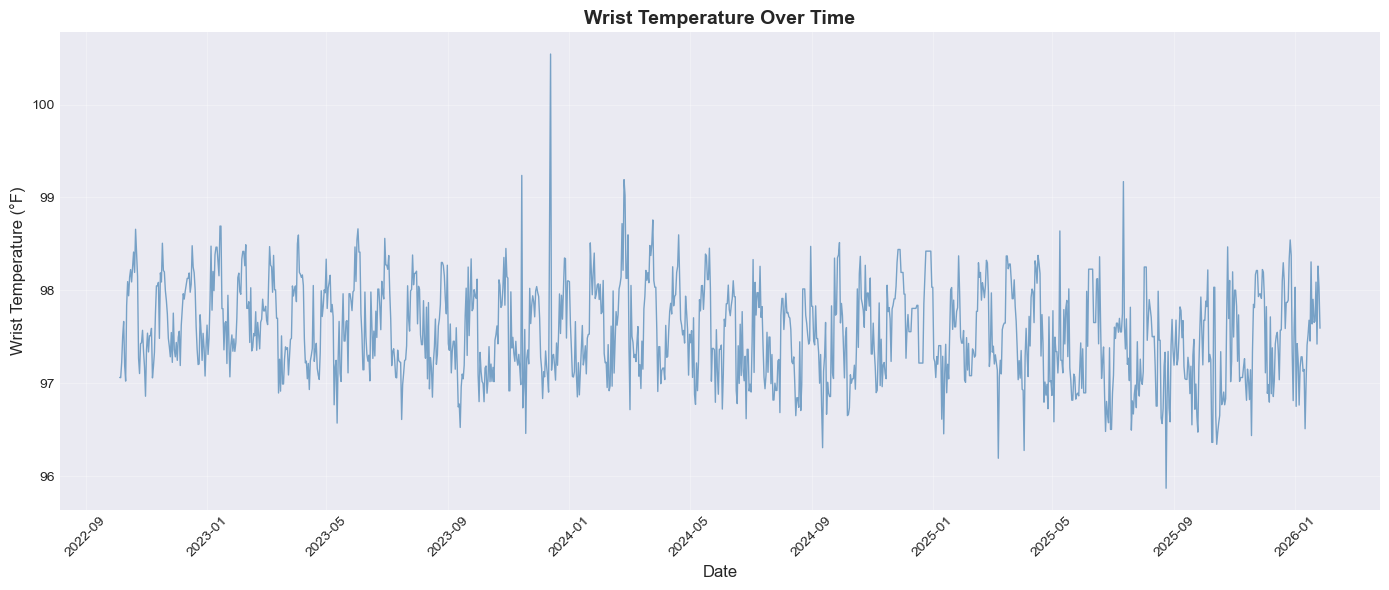

Figure saved to outputs/figures/


In [18]:
# 7. Visualization - Time Series Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean.index, df_clean['value'], 
        linewidth=1, alpha=0.7, color='steelblue')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Wrist Temperature (°F)', fontsize=12)
ax.set_title('Wrist Temperature Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()

# Display in notebook
plt.show()

# Save high-quality version
fig.savefig('../outputs/figures/temperature_timeseries.png', 
            dpi=300, bbox_inches='tight')
print("Figure saved to outputs/figures/")

Detected peak locations (approximate modes): [97.37206383 97.93841728]


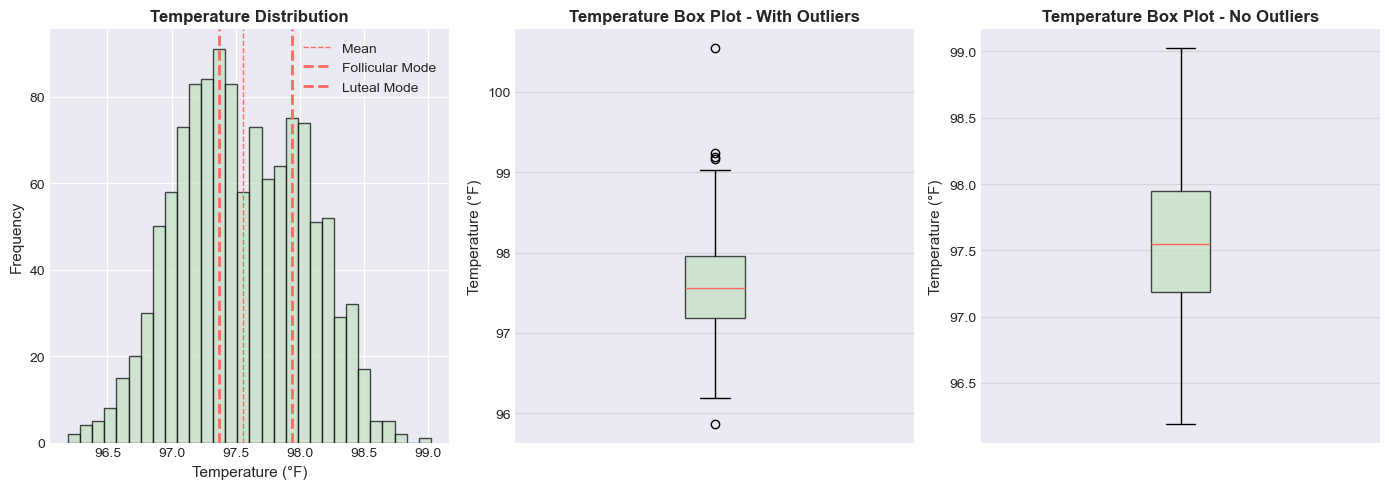

In [74]:
# Cell 8: Visualization - Distribution Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Temperature distribution is bimodal. Analyze the peaks
hist, bin_edges = np.histogram(df_clean_no_outliers['value'], bins=30)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, properties = find_peaks(hist, height=74)
peak_locations = bin_centers[peaks]
print(f"Detected peak locations (approximate modes): {peak_locations}")


# Histogram
axes[0].hist(df_clean_no_outliers['value'], bins=30, 
             color='#C1E1C1', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Temperature (°F)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Temperature Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(df_clean['value'].mean(), 
                color='#FF6961', linestyle='--', linewidth=1, label='Mean')
axes[0].axvline(peak_locations[0], 
                color='#FF6961', linestyle='--', linewidth=2, label='Follicular Mode')
axes[0].axvline(peak_locations[1], 
                color='#FF6961', linestyle='--', linewidth=2, label='Luteal Mode')
axes[0].legend()

# Box plot - with outliers
bp = axes[1].boxplot(
    df_clean['value'], 
    vert=True,
    patch_artist=True,  # Enable filling
    widths=0.15,
    meanline=True,
    showmeans=True
)
# Style the box plot elements
for patch in bp['boxes']:
    patch.set_facecolor('#C1E1C1')
    patch.set_alpha(0.7)
    patch.set_linewidth(1)

for whisker in bp['whiskers']:
    whisker.set(linewidth=1, color='black')

for cap in bp['caps']:
    cap.set(linewidth=1, color='black')

for median in bp['medians']:
    median.set(linewidth=0, color='#FF6961', label='Median')

for mean in bp['means']:
    mean.set(linewidth=1, color='#FF6961', linestyle='-', label='Mean')
    
axes[1].set_ylabel('Temperature (°F)', fontsize=11)
axes[1].get_xaxis().set_visible(False)
axes[1].set_title('Temperature Box Plot - With Outliers', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, linewidth=1, color='darkgrey')

# Box plot - no outliers
bp2 = axes[2].boxplot(
    df_clean_no_outliers['value'], 
    vert=True,
    patch_artist=True,  # Enable filling
    widths=0.15,
    meanline=True,
    showmeans=True
)
# Style the box plot elements
for patch in bp2['boxes']:
    patch.set_facecolor('#C1E1C1')
    patch.set_alpha(0.7)
    patch.set_linewidth(1)

for whisker in bp2['whiskers']:
    whisker.set(linewidth=1, color='black')

for cap in bp2['caps']:
    cap.set(linewidth=1, color='black')

for median in bp2['medians']:
    median.set(linewidth=0, color='#FF6961', label='Median')

for mean in bp2['means']:
    mean.set(linewidth=1, color='#FF6961', linestyle='-', label='Mean')
    
axes[2].set_ylabel('Temperature (°F)', fontsize=11)
axes[2].get_xaxis().set_visible(False)
axes[2].set_title('Temperature Box Plot - No Outliers', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, linewidth=1, color='darkgrey')

plt.tight_layout()
plt.show()

# Save
fig.savefig('../outputs/figures/temperature_distribution.png', 
            dpi=300, bbox_inches='tight')

In [83]:
# 9. Save Cleaned Data
df_clean.to_csv('../data/processed/temperature_clean.csv', index=False)
print(f"Cleaned data saved: {df_clean.shape[0]} rows")
print(f"Columns: {df_clean.columns.tolist()}")

df_clean_no_outliers.to_csv('../data/processed/temperature_clean_no_outliers.csv', index=False)
print(f"Cleaned data (no outliers) saved: {df_clean_no_outliers.shape[0]} rows")
print(f"Columns: {df_clean_no_outliers.columns.tolist()}")

Cleaned data saved: 1210 rows
Columns: ['type', 'sourceName', 'sourceVersion', 'productType', 'device', 'startDate', 'endDate', 'unit', 'value', 'HKAlgorithmVersion', 'effectiveDate']
Cleaned data (no outliers) saved: 1205 rows
Columns: ['type', 'sourceName', 'sourceVersion', 'productType', 'device', 'startDate', 'endDate', 'unit', 'value', 'HKAlgorithmVersion', 'effectiveDate']


# 10. Key Findings

## Phase 1 Summary

**Dataset Overview:**
- Total wrist temperature observations: 1209 (1/day)
- Date range: 2022-10-05 to 2026-01-26
- Missing temperature recordings: 9%

**Temperature Insights:**
- Average temperature: 97.55°F, but temperature follows a clear bimodal distribution peaking around 97.4 and 97.9°F.
- Raw temperature range: 95.87 - 100.54°F; normalized temperature range: 96.19 - 99.02°F.
- Standard deviation: 0.51°F

**Data Quality:**
- Issues:
    - Raw CSV export had 1 row of content not part of the data
    - 9% of dates in range (109 days) were missing
    - A few outlying temperatures were present outside a healthy temperature range, suggesting measurement error or a period of illness (fever etc).
- Cleaning steps taken:
    - Skip importing first row of CSV into DF (not a header)
    - Missing dates were inserted and temperatures forward-filled from last valid temp recorded. I chose this approach due to the bimodal distribution of temps, since if I had filled with the mean then distribution would appear flattened, and if I had removed those rows it could incorrectly estimate when the bimonthly temp shift occurs.
    - Outlier temperatures were determined based on the IQR method. I made two versions of the cleaned dataset, one with outliers kept in (useful in observing the impact of sleep, illness, and travel on temperature recordings) and one with them removed (for calculating averages, since cycle temps are otherwise resilient to major external influences).

**So What?**
- The data agrees with basic principles of female basal body temperature fluctuations. That is, that basal body temperature is maintained at a certain lower value from the onset of menstruation until ovulation before rising to a new average around 0.5°F above the previous temp until the next cycle begins, as opposed to being closer to a normal distribution.

**Next Steps:**
- Phase 2: Calculate cycle days and add rolling averages